<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
    <h2>Специализация "Машинное обучение и анализ данных"</h2>
</center>
<center>

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам

# <center> Feature Engineering and Exploratory Data Analysis

## Цели проекта

Данная работы выполнена в рамках учебного соревнования Kaggle Catch Me If You Can ("Alice") (https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2)

Из описания задачи соревнования:

_Будем решать задачу идентификации взломщика по его поведению в сети Интернет. 
Aлгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой)._

_Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud._

Целевая метрика – ROC AUC.

In [1]:
import notebook_helper
notebook_helper.set_working_folder()

Current working folder: C:\Users\Roman\OneDrive\Data Science\mlops


In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm

from src.configuration.config import get_config

In [3]:
cfg = get_config()

INFO:root:Loading configuration file conf/config.yaml
INFO:root:Loaded configuration file conf/config.yaml


## Aнализ признаков

In [4]:
train_df = pd.read_csv(
    "data/raw/train_sessions.csv",
    index_col="session_id",
    parse_dates=cfg.data.date_cols,
)

test_df = pd.read_csv(
    "data/raw/test_sessions.csv",
    index_col="session_id",
    parse_dates=cfg.data.date_cols,
)

train_df_alice = train_df[train_df.target == 1]
train_df_rest = train_df[train_df.target == 0]

### Посещенные сайты
Признаки site_j скорее всего не будут иметь смысла в задаче классификации сессий, т.к. маловероятно, что порядковый номер в сессии будет иметь значение. Эти признаки больше похожи на bag of words, поэтому их надо будет преобразовать в подобный формат.

### Время работы в интернете

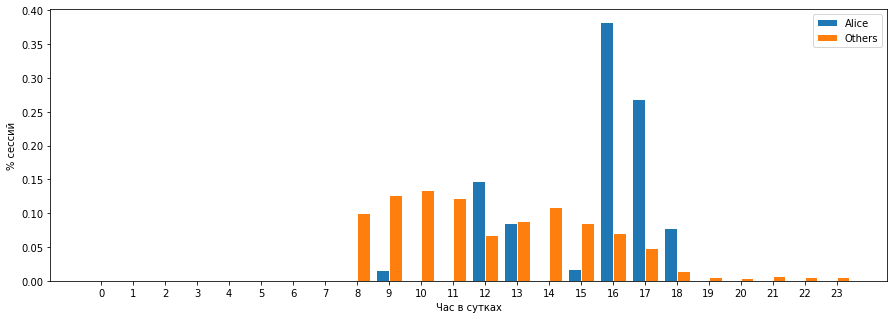

In [5]:
# session start: minutes after 00:00
day_minutes_alice = (
    train_df_alice.time1.dt.hour * 60 + train_df_alice.time1.dt.minute
).value_counts()
day_minutes_rest = (
    train_df_rest.time1.dt.hour * 60 + train_df_rest.time1.dt.minute
).value_counts()
plt.figure(figsize=(15, 5))
plt.hist(
    [train_df_alice.time1.dt.hour, train_df_rest.time1.dt.hour],
    density=True,
    label=["Alice", "Others"],
    bins=range(0, 25),
    edgecolor="w",
    align="right",
)
plt.xlabel("Час в сутках")
plt.ylabel("% сессий")
plt.legend()
plt.xticks(ticks=range(1, 25), labels=range(0, 24))
plt.show()

Alice появляется в интернете меньше, чем все остальные. Пики работы так же не совпадают. Время в сутках стоит учитывать, как признак.

Есть часы, когда Alice появляется редко. Надо отдельно проверить распределение времени внутри часа.

In [6]:
train_df_alice.time1.dt.hour.value_counts().sort_index()

9      38
11      3
12    340
13    196
14      4
15     40
16    879
17    618
18    179
Name: time1, dtype: int64

Нужно проверить распределение внутри часов 9, 11, 14, 15, 18

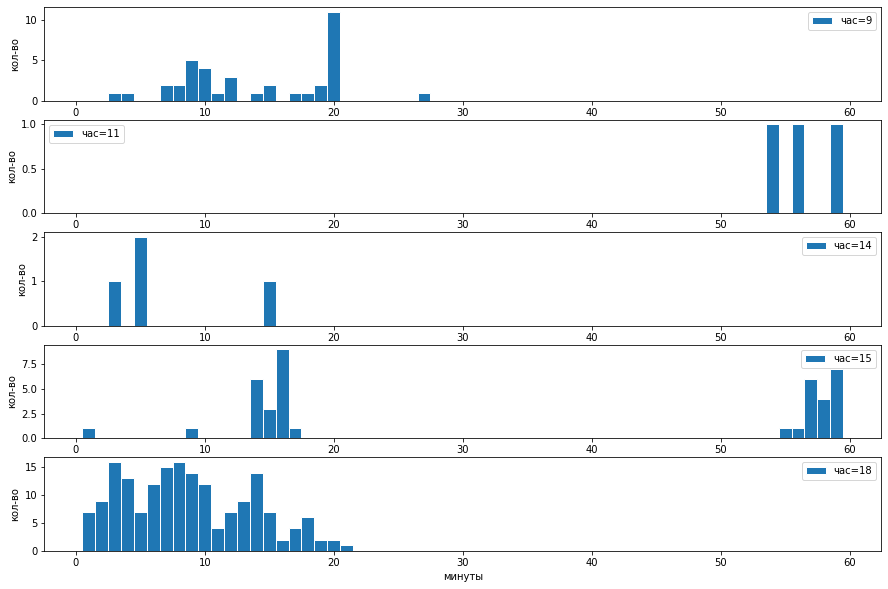

In [7]:
hours = [9, 11, 14, 15, 18]
fig, ax = plt.subplots(nrows=len(hours), ncols=1, figsize=(15, 10))
for i, h in enumerate(hours):
    minutes = train_df_alice[train_df_alice.time1.dt.hour == h].time1.dt.minute
    ax[i].hist(
        minutes, bins=range(0, 60), edgecolor="w", align="right", label="час=%d" % h
    )
    ax[i].legend()
    ax[i].set_xlabel("минуты")
    ax[i].set_ylabel("кол-во")

plt.show()

Судя по всему Alice появляется в сети в 2 определённых промежутка времени. Нужно исследовать их границы. Возможно, есть связь с днями недели.

### День недели и время

In [8]:
pd.crosstab(train_df_alice.time1.dt.day_of_week, train_df_alice.time1.dt.hour)

time1  9   11   12   13  14  15   16   17   18
time1                                         
0       0   0    0    0   0   9  445  311  111
1       0   1  107   36   1   3  152  169   39
2       0   0    0    0   0   6    6   16   10
3       0   0   57   32   0  22  276   87   13
4      38   1  176  128   3   0    0    0    0
5       0   0    0    0   0   0    0   35    6
6       0   1    0    0   0   0    0    0    0

Есть ли часы, в которые Alice была в сети только в один день?

In [9]:
# find hours when Alice was in Internet only on 1-2 particular dates
print("Alice в эти часы была в интернете только в 1-2 даты")
for h in np.unique(train_df_alice.time1.dt.hour):
    days = train_df_alice[
        train_df_alice.time1.dt.hour == h
    ].time1.dt.date.value_counts()
    if len(days) <= 2:
        print("Час:", h, days.index.values)

Alice в эти часы была в интернете только в 1-2 даты
Час: 9 [datetime.date(2013, 4, 12)]
Час: 14 [datetime.date(2013, 11, 15) datetime.date(2014, 1, 28)]


В 9 часов Alice была активна только в один день, причём сессий в этот день было много. Это нетипичное поведение и эти сессии надо убрать из обучения.

Alice сидит в Интернете в разные дни в разное время. Достаточно ли данных, чтобы принять решение, что в разные дни Alice сидит в интернете в разное время?

In [10]:
for d in sorted(np.unique(train_df_alice.time1.dt.day_of_week)):
    print("Day:", d)
    print(
        sorted(
            np.unique(
                train_df_alice[
                    train_df_alice.time1.dt.day_of_week == d
                ].time1.dt.date.apply(datetime.date.isoformat)
            )
        )
    )

Day: 0
['2013-11-18', '2013-12-16', '2014-01-20', '2014-02-17', '2014-02-24', '2014-03-24', '2014-03-31', '2014-04-14']
Day: 1
['2013-02-12', '2013-11-19', '2013-12-17', '2014-01-14', '2014-01-28', '2014-02-18', '2014-02-25', '2014-03-18', '2014-03-25', '2014-04-15']
Day: 2
['2014-04-02']
Day: 3
['2013-09-12', '2014-01-16', '2014-02-13', '2014-02-20', '2014-02-27', '2014-03-20']
Day: 4
['2013-04-12', '2013-11-15', '2013-11-22', '2013-11-29']
Day: 5
['2014-01-04']
Day: 6
['2014-03-02']


Понедельник. Данных достаточно. Видимо, Alice сидит в интернете только во второй половине дня.

Вторник, Четверг. Данных достаточно. Alice появляется в сети до обеда и ближе к концу рабочего дня.

Среда. Данных мало. Есть только вечерняя активность, то наверняка сказаться нельзя. Лучше выбрать промежуток, как у остальных рабочих дней.

Пятница. Данные достаточно. Alice появляется в сети до обеда.

Суббота и Воскресенье. Данных мало. Лучше выбрать промежуток, который больше соответствует большинству дней.

Анализ промежутка границ промежутков времени, в которых Alice появляется в Интернете.

Период часов активности [11, 14]. Левая граница: 12:06:06.600000. Правая граница: 13:49:55.150000
Период часов активности [15, 18]. Левая граница: 16:00:36. Правая граница: 18:12:14.625000


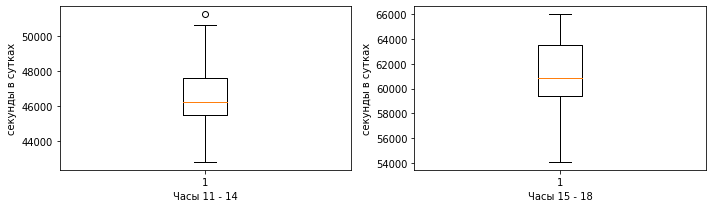

In [11]:
periods = [[11, 14], [15, 18]]

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))

for i, p in enumerate(periods):
    times = train_df_alice[
        (train_df_alice.time1.dt.hour >= p[0]) & (train_df_alice.time1.dt.hour <= p[1])
    ].time1.dt.time
    time_seconds = [x.hour * 3600 + x.minute * 60 + x.second for x in times]
    q_low, q_high = np.quantile(time_seconds, [0.025, 0.975])
    lower_bound = (
        datetime.datetime(1900, 1, 1) + datetime.timedelta(seconds=q_low)
    ).time()
    upper_bound = (
        datetime.datetime(1900, 1, 1) + datetime.timedelta(seconds=q_high)
    ).time()
    print(
        "Период часов активности [{0}, {1}]. Левая граница: {2}. Правая граница: {3}".format(
            p[0], p[1], lower_bound, upper_bound
        )
    )
    ax[i].boxplot(time_seconds)
    ax[i].set_ylabel("секунды в сутках")
    ax[i].set_xlabel("Часы %d - %d" % (p[0], p[1]))

fig.tight_layout()

In [12]:
np.unique(train_df_alice.time1.dt.hour)
alice_timing = []
alice_hours = np.unique(train_df_alice.time1.dt.hour)
for d in range(0, 7):
    day_timing = []
    for h in alice_hours:
        ds = train_df_alice[
            (train_df_alice.time1.dt.day_of_week == d)
            & (train_df_alice.time1.dt.hour == h)
        ]
        day_timing.append(np.min(ds.time1.dt.time))
        day_timing.append(np.max(ds.time1.dt.time))
    alice_timing.append(day_timing)
pd.DataFrame(
    alice_timing,
    columns=[x for h in alice_hours for x in ((str(h) + "_first", str(h) + "_last"))],
)

9_first    9_last  11_first   11_last  12_first   12_last  13_first  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN  11:53:25  11:53:25  12:03:18  12:59:49  13:00:59   
2       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3       NaN       NaN       NaN       NaN  12:29:33  12:58:57  13:02:02   
4  09:02:48  09:26:15  11:59:01  11:59:01  12:13:22  12:59:59  13:00:33   
5       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6       NaN       NaN  11:55:52  11:55:52       NaN       NaN       NaN   

    13_last  14_first   14_last  15_first   15_last  16_first   16_last  \
0       NaN       NaN       NaN  15:57:42  15:59:54  16:00:13  16:59:33   
1  13:50:09  14:14:19  14:14:19  15:54:33  15:57:21  16:00:36  16:59:59   
2       NaN       NaN       NaN  15:56:20  15:57:02  16:03:44  16:05:03   
3  13:47:49       NaN       NaN  15:00:28  15:55:50  16:00:36  16:59:57   
4  13:57:40  14:02:50  14:04:08       NaN       NaN       NaN       NaN   
5       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

   17_first   17_last  18_first   18_last  
0  17:00:21  17:59:52  18:00:10  18:19:24  
1  17:00:03  17:59:49  18:00:49  18:13:05  
2  17:09:22  17:49:58  18:01:47  18:09:01  
3  17:00:25  17:59:56  18:00:45  18:20:54  
4       NaN       NaN       NaN       NaN  
5  17:29:19  17:57:45  18:09:16  18:11:07  
6       NaN       NaN       NaN       NaN

Распределение времени остальных пользователей

In [13]:
pd.crosstab(train_df_rest.time1.dt.day_of_week, train_df_rest.time1.dt.hour)

time1  7     8     9     10    11    12    13    14    15    16    17   18  \
time1                                                                        
0      43  3671  4472  5012  5317  2055  4108  4145  3528  3478  2091  540   
1      72  5599  6456  6576  5220  3014  3651  6137  4180  3121  2603  636   
2      72  6538  8520  7479  7672  4260  4245  4959  4841  4191  2052  559   
3      63  4356  4956  4917  4823  3113  4679  5725  3756  3186  2472  782   
4      55  2899  4306  7087  5412  3551  4086  4006  3472  2512  1832  558   
5      26  1965  2626  2191  1910   583   766  1241   981   758   644  364   
6      10   341   367   414   441   504   821  1089   842   614   518  280   

time1   19   20   21   22   23  
time1                           
0      328  227  298  183  141  
1      240  136  126  195  189  
2       81   74  147  118  125  
3      287  112  161  125  147  
4      209  210  245  231  123  
5      169  272  466  367  429  
6      226  169  262  248  185

Остальные сидят в сети более равномерно

Нужно попробовать использовать 2 промежутка времени в качестве признака, что сессия принадлежит Alice:
- [12:06:06, 13:49:55]
- [16:00:36, 18:12:14]

Стоит попробовать выбирать один или два промежутка в зависимости от дня недели. Однако это может оказаться неверным решением, т.к. в обучающей выборке мало данных. Текущее распределение промежутков по дням недели может оказаться случайным.

### Дни работы в Интернете

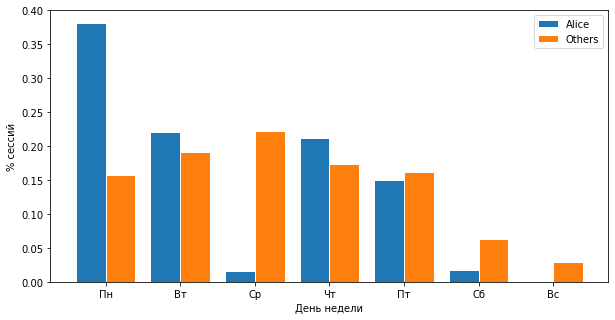

In [14]:
plt.figure(figsize=(10, 5))
bins = len(train_df.time1.dt.dayofweek.value_counts())
plt.hist(
    [train_df_alice.time1.dt.dayofweek, train_df_rest.time1.dt.dayofweek],
    density=True,
    label=["Alice", "Others"],
    bins=range(0, 8),
    edgecolor="w",
    align="right",
)
plt.xlabel("День недели")
plt.ylabel("% сессий")
plt.xticks(ticks=range(1, 8), labels=["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
plt.legend()
plt.show()

Недельный график Alice явно отличается от остальных. День недели нужно использовать, как признак.

### Месячный график

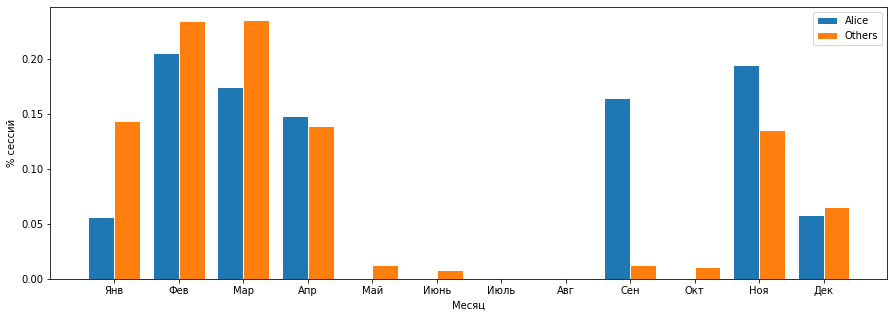

In [15]:
plt.figure(figsize=(15, 5))
bins = len(train_df.time1.dt.dayofweek.value_counts())
plt.hist(
    [train_df_alice.time1.dt.month, train_df_rest.time1.dt.month],
    density=True,
    label=["Alice", "Others"],
    bins=list(range(1, 14)),
    edgecolor="w",
    align="right",
)
plt.xlabel("Месяц")
plt.ylabel("% сессий")
plt.xticks(
    ticks=range(2, 14),
    labels=[
        "Янв",
        "Фев",
        "Мар",
        "Апр",
        "Май",
        "Июнь",
        "Июль",
        "Авг",
        "Сен",
        "Окт",
        "Ноя",
        "Дек",
    ],
)
plt.legend()
plt.show()

Alice сидит в Интернете не круглый год. Возможно, что надо использовать месяц или декаду дней от начала года в качестве признака.

Нужно проверить распределение дней в "крайних" месяцах и около нового года.

In [16]:
train_df_alice.time1.dt.month.value_counts().sort_index()

1     129
2     471
3     400
4     340
9     377
11    446
12    134
Name: time1, dtype: int64

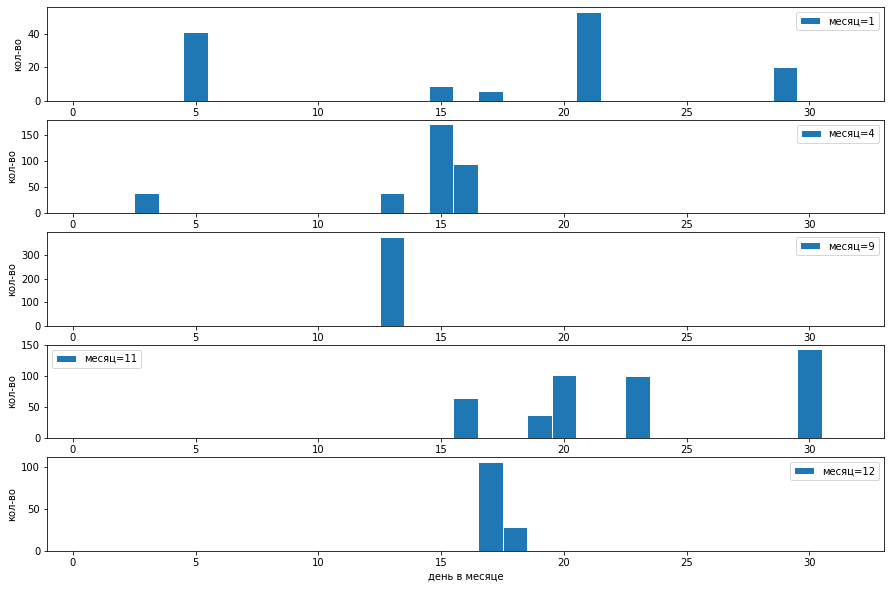

In [17]:
months = [1, 4, 9, 11, 12]
fig, ax = plt.subplots(nrows=len(months), ncols=1, figsize=(15, 10))
for i, m in enumerate(months):
    minutes = train_df_alice[train_df_alice.time1.dt.month == m].time1.dt.day
    ax[i].hist(
        minutes, bins=range(0, 32), edgecolor="w", align="right", label="месяц=%d" % m
    )
    ax[i].legend()
    ax[i].set_xlabel("день в месяце")
    ax[i].set_ylabel("кол-во")

plt.show()

Хорошей зависимости не видно, но можно отдельно проверить Новый год.

In [18]:
print(
    "Временной промежуток тренировочной сессии: {0} - {1}".format(
        train_df[cfg.data.date_cols].min().min(), train_df[cfg.data.date_cols].max().max()
    )
)
print(
    "Временной промежуток тестовой сессии: {0} - {1}".format(
        test_df[cfg.data.date_cols].min().min(), test_df[cfg.data.date_cols].max().max()
    )
)


Временной промежуток тренировочной сессии: 2013-01-12 08:05:57 - 2014-04-30 23:40:05
Временной промежуток тестовой сессии: 2014-05-01 17:14:03 - 2014-12-05 23:56:23


Тестовая сессия в другом периоде. Признак Нового года не имеет смысла.

Летнее расписание могло поменяться. Возможно, что добавление месяца только ухудшит прогноз.

### Недельный график

C:\Users\Roman\AppData\Local\Temp\ipykernel_19672\697023796.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  ax[0].plot(train_df_alice.time1.dt.week.value_counts().sort_index(), label="Alice")
C:\Users\Roman\AppData\Local\Temp\ipykernel_19672\697023796.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_df_rest.time1.dt.week.value_counts().sort_index(),


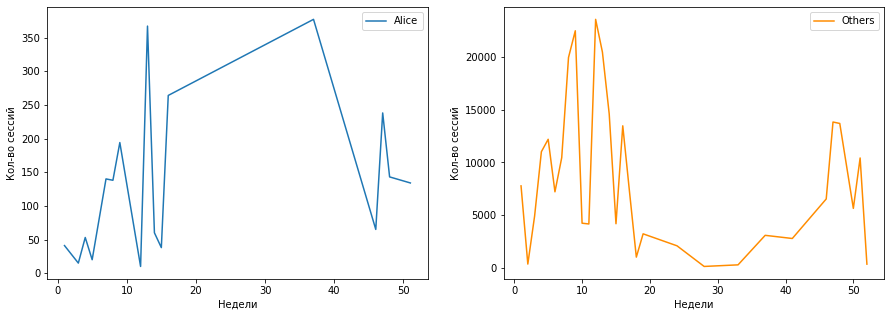

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].plot(train_df_alice.time1.dt.week.value_counts().sort_index(), label="Alice")
ax[1].plot(
    train_df_rest.time1.dt.week.value_counts().sort_index(),
    label="Others",
    color="darkorange",
)
for a in ax:
    a.set_xlabel("Недели")
    a.set_ylabel("Кол-во сессий")
    a.legend()
plt.show()

Распределение по неделями выглядит сильно отличающимся, можно попробовать использовать в качестве признака.

In [20]:
train_df_alice.time1.dt.week.value_counts().sort_index()

C:\Users\Roman\AppData\Local\Temp\ipykernel_19672\2867246894.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_df_alice.time1.dt.week.value_counts().sort_index()


1      41
3      15
4      53
5      20
7     140
8     138
9     194
12     10
13    367
14     60
15     38
16    264
37    377
46     65
47    238
48    143
51    134
Name: time1, dtype: int64

Есть перерывы в неделях: 2, 6, 49, 50. На какие недели приходятся тестовые данные?

In [21]:
test_df.time1.dt.week.value_counts().sort_index()

C:\Users\Roman\AppData\Local\Temp\ipykernel_19672\3038961724.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test_df.time1.dt.week.value_counts().sort_index()


18    10048
19      304
20     7228
21     5606
22     4021
23     2838
27    10837
31     3729
32     4117
36     3627
40     8157
44     6378
45     3519
49    12388
Name: time1, dtype: int64

Стоит дополнить данные для обучения неделей 49.

### Длина сессии (сайты)

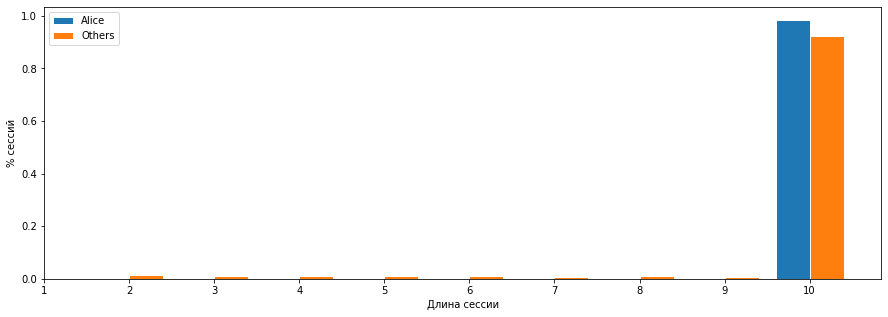

In [22]:
sites_count_alice = len(cfg.data.site_cols) - np.sum(
    train_df_alice[cfg.data.site_cols].isna(), axis=1
)
sites_count_rest = len(cfg.data.site_cols) - np.sum(
    train_df_rest[cfg.data.site_cols].isna(), axis=1
)
plt.figure(figsize=(15, 5))
plt.hist(
    [sites_count_alice, sites_count_rest],
    density=True,
    label=["Alice", "Others"],
    bins=range(2, 12),
    edgecolor="w",
    align="right",
)
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.xticks(ticks=range(2, 12), labels=range(1, 11))
plt.show()

В основном сессии имеют длину 10. Надо посмотреть отдельно сессии длиины меньше 10.

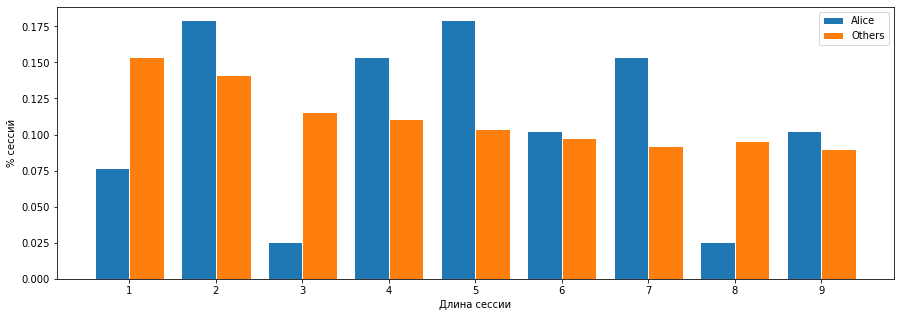

In [23]:
sites_count_alice_9 = sites_count_alice[sites_count_alice != 10]
sites_count_rest_9 = sites_count_rest[sites_count_rest != 10]
plt.figure(figsize=(15, 5))
plt.hist(
    [sites_count_alice_9, sites_count_rest_9],
    density=True,
    label=["Alice", "Others"],
    bins=range(1, 11),
    edgecolor="w",
    align="right",
)
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.xticks(ticks=range(2, 11), labels=range(1, 10))
plt.show()

По некоторым сессиям разница есть. Можно добавить, как категориальный признак.

По некоторым сессиям разница есть. Можно добавить, как категориальный признак.

### Длина сессии (время)

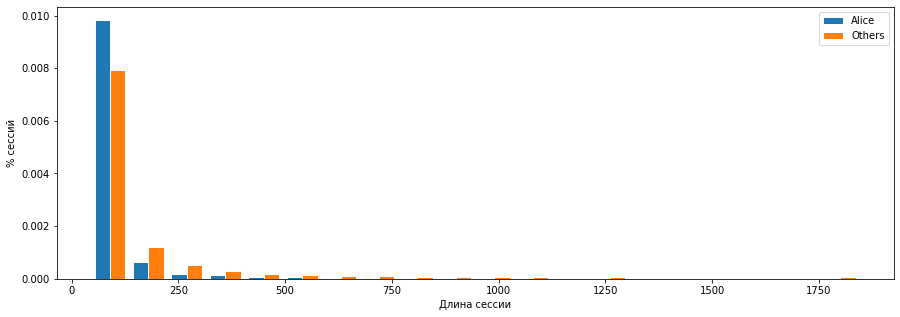

In [24]:
session_time_alice = (
    np.max(train_df_alice[cfg.data.date_cols], axis=1)
    - np.min(train_df_alice[cfg.data.date_cols], axis=1)
).dt.seconds
session_time_rest = (
    np.max(train_df_rest[cfg.data.date_cols], axis=1)
    - np.min(train_df_rest[cfg.data.date_cols], axis=1)
).dt.seconds
session_time_all = (
    np.max(train_df[cfg.data.date_cols], axis=1) - np.min(train_df[cfg.data.date_cols], axis=1)
).dt.seconds
plt.figure(figsize=(15, 5))
plt.hist(
    [session_time_alice, session_time_rest],
    density=True,
    label=["Alice", "Others"],
    bins=20,
    edgecolor="w",
    align="right",
)
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.show()

Отдельно короткие сессии

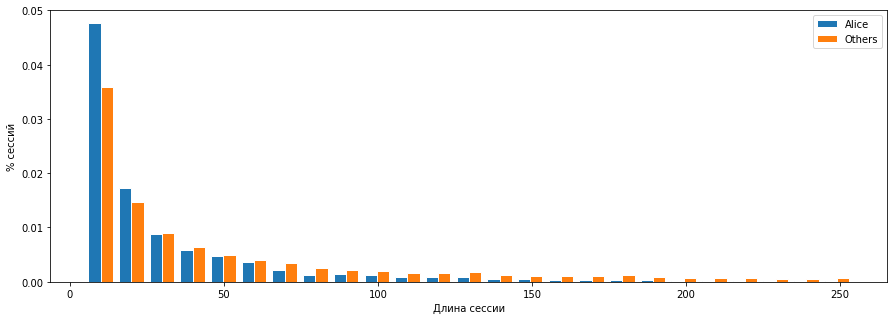

In [25]:
session_time_alice = session_time_alice[session_time_alice < 250]
session_time_rest = session_time_rest[session_time_rest < 250]
plt.figure(figsize=(15, 5))
plt.hist(
    [session_time_alice, session_time_rest],
    density=True,
    label=["Alice", "Others"],
    bins=25,
    edgecolor="w",
    align="right",
)
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.show()

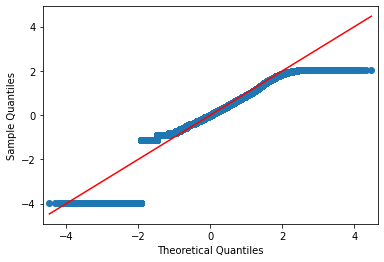

In [26]:
sm.qqplot(session_time_all**0.1, fit=True, line="s")
plt.show()

### Количество уникальных сайтов в сессии

In [27]:
sites_unique_alice = train_df_alice[cfg.data.site_cols].nunique(axis=1)
sites_unique_rest = train_df_rest[cfg.data.site_cols].nunique(axis=1)
sites_unique_all = train_df[cfg.data.site_cols].nunique(axis=1)

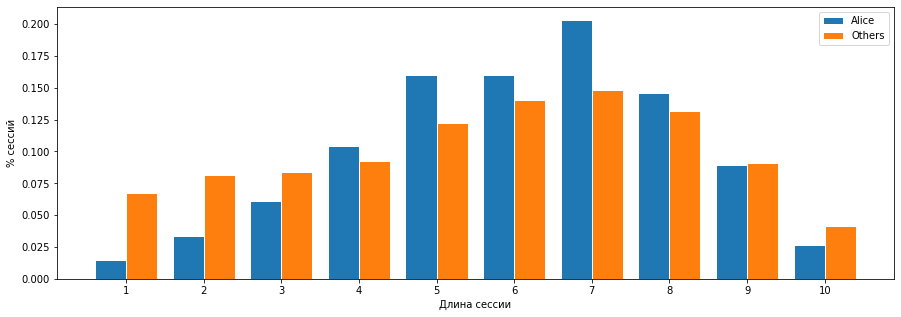

In [28]:
plt.figure(figsize=(15, 5))
plt.hist(
    [sites_unique_alice, sites_unique_rest],
    density=True,
    label=["Alice", "Others"],
    bins=range(1, 12),
    edgecolor="w",
    align="right",
)
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.xticks(ticks=range(2, 12), labels=range(1, 11))
plt.show()

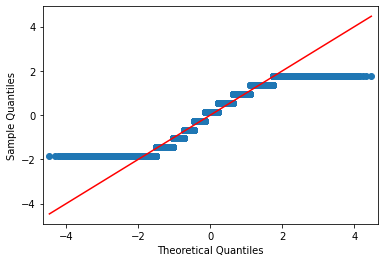

In [29]:
sm.qqplot(sites_unique_all, fit=True, line="s")
plt.show()

### Среднее время на сайт

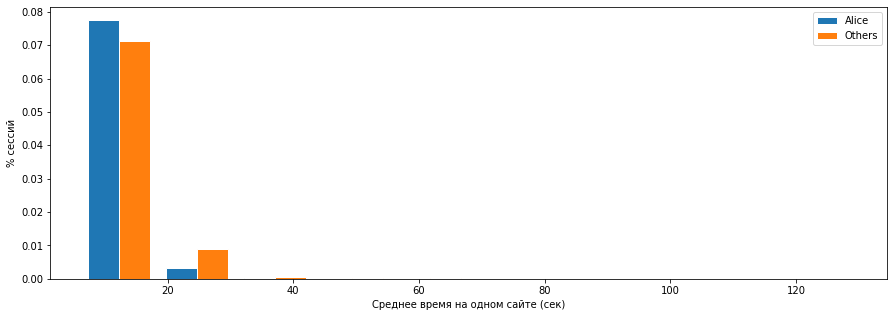

In [30]:
time_per_site_alice = session_time_alice / sites_count_alice
time_per_site_rest = session_time_rest / sites_count_rest
sites_count_all = len(cfg.data.site_cols) - np.sum(train_df[cfg.data.site_cols].isna(), axis=1)
time_per_site_all = session_time_all / sites_count_all
plt.figure(figsize=(15, 5))
plt.hist(
    [time_per_site_alice, time_per_site_rest],
    density=True,
    label=["Alice", "Others"],
    bins=10,
    edgecolor="w",
    align="right",
)
plt.xlabel("Среднее время на одном сайте (сек)")
plt.ylabel("% сессий")
plt.legend()
plt.show()


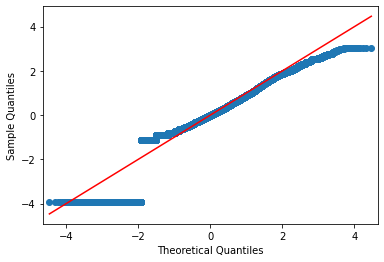

In [31]:
sm.qqplot(time_per_site_all**0.1, fit=True, line="s")
plt.show()

### Различия в посещаемых сайтах

In [32]:
# load sites dictionary
with open("data/raw/site_dic.pkl", "rb") as site_dict_file:
    site_dict = pickle.load(site_dict_file)

list(site_dict.items())[:10]

site_dict_reverse = {code: site for (site, code) in site_dict.items()}

In [33]:
alice_site_count = (
    train_df_alice[cfg.data.site_cols]
    .applymap(site_dict_reverse.get)
    .melt()
    .value.value_counts()
)
alice_site_count.head(20)

i1.ytimg.com                            1382
s.youtube.com                           1354
www.youtube.com                         1307
www.facebook.com                         897
www.google.fr                            857
r4---sn-gxo5uxg-jqbe.googlevideo.com     609
r1---sn-gxo5uxg-jqbe.googlevideo.com     522
apis.google.com                          522
s.ytimg.com                              451
r2---sn-gxo5uxg-jqbe.googlevideo.com     447
www.google.com                           437
s-static.ak.facebook.com                 381
r3---sn-gxo5uxg-jqbe.googlevideo.com     371
twitter.com                              293
static.ak.facebook.com                   291
vk.com                                   286
translate.google.fr                      274
platform.twitter.com                     272
yt3.ggpht.com                            236
mts0.google.com                          215
Name: value, dtype: int64

Судя по всему Alice любит смотреть видео контент. выбираем всё, что связано с видео и аудио. Ключевые слова после анализа сайтов Alice:

ytimg, youtube, video, movie, stream, cinema, film, tv, yt3, youwatch, media, mtv, music, radio

Какие сайты интересны остальным пользователям?

In [34]:
rest_site_count = (
    train_df_rest[cfg.data.site_cols]
    .applymap(site_dict_reverse.get)
    .melt()
    .value.value_counts()
)
rest_site_count.head(15)

www.google.fr                    122919
www.google.com                    87182
annotathon.org                    77055
apis.google.com                   57736
www.facebook.com                  53197
www.bing.com                      46355
blast.ncbi.nlm.nih.gov            43841
www.ncbi.nlm.nih.gov              38194
clients1.google.com               35879
mail.google.com                   35178
plus.google.com                   30616
s.youtube.com                     30037
safebrowsing-cache.google.com     27812
accounts.google.com               25154
twitter.com                       23433
Name: value, dtype: int64

Можно ли сделать различие между сайтами, которые посещает Alice и остальные?

Какую часть от всех запросов составляют топ-сайты. 

In [35]:
print("Часть от всех запросов Alice, которые покрывают топ-сайты")
top_head = 100
alice_site_rolling = (
    alice_site_count.head(top_head).rolling(window=top_head, min_periods=1).sum()
    / alice_site_count.sum()
)
for i in range(19, top_head, 20):
    print(
        "Alice топ-{0} сайтов покрывают {1} от всех сайтов".format(
            i + 1, alice_site_rolling[i]
        )
    )

print("\nЧасть от всех запросов остальных, которые покрывают топ-сайты")
top_head = 300
rest_site_rolling = (
    rest_site_count.head(top_head).rolling(window=top_head, min_periods=1).sum()
    / rest_site_count.sum()
)
for i in range(39, top_head, 40):
    print(
        "Alice топ-{0} сайтов покрывают {1} от всех сайтов".format(
            i + 1, rest_site_rolling[i]
        )
    )

Часть от всех запросов Alice, которые покрывают топ-сайты
Alice топ-20 сайтов покрывают 0.5008564275989283 от всех сайтов
Alice топ-40 сайтов покрывают 0.6306820677236593 от всех сайтов
Alice топ-60 сайтов покрывают 0.6996793886424525 от всех сайтов
Alice топ-80 сайтов покрывают 0.7449602529755369 от всех сайтов
Alice топ-100 сайтов покрывают 0.7759234046291009 от всех сайтов

Часть от всех запросов остальных, которые покрывают топ-сайты
Alice топ-40 сайтов покрывают 0.4554508137906566 от всех сайтов
Alice топ-80 сайтов покрывают 0.5592510138650464 от всех сайтов
Alice топ-120 сайтов покрывают 0.6135669012861745 от всех сайтов
Alice топ-160 сайтов покрывают 0.6470686926255727 от всех сайтов
Alice топ-200 сайтов покрывают 0.6726382163840926 от всех сайтов
Alice топ-240 сайтов покрывают 0.6933606849221647 от всех сайтов
Alice топ-280 сайтов покрывают 0.7103293529045304 от всех сайтов


Насколько отличабются топ-сайты Alice и остальных?

In [36]:
alice_site_set = set(alice_site_count.head(40).index).difference(
    rest_site_count.head(250).index
)
alice_site_set

{'media.melty.fr',
 'vk.com',
 'www.info-jeunes.net',
 'www.melty.fr',
 'wwwd.caf.fr',
 'youwatch.org'}

Насколько отличабются топ-сайты остальных от Alice?

In [37]:
rest_site_set = set(rest_site_count.head(50).index).difference(alice_site_count.index)
rest_site_set

{'annotathon.org',
 'api.twitter.com',
 'blast.ncbi.nlm.nih.gov',
 'download.jboss.org',
 'fr-mg42.mail.yahoo.com',
 'fr.openclassrooms.com',
 'mail.google.com',
 'ocsp.digicert.com',
 'plus.google.com',
 'safebrowsing-cache.google.com',
 'safebrowsing.clients.google.com',
 'ts1.mm.bing.net',
 'www.ncbi.nlm.nih.gov',
 'www.phylogeny.fr'}

Стоит попробовать добавить признаки "любимых" сайтов Alice и остальных пользователей.